# The Battle of Neighborhoods

This project focusses on the issue of finding an apartment to rent a city like Vienna which is the largest city in Austria. Potential stakeholders for this project would be people looking to rent an apartment. Business problem would be providing people with information like
1. Which district has cheaper rent 
2. Choose to live in residential or commercial areas and can see for example which residential districts is best Or
If they already live in one of the 23 districts in Vienna, they will be able to see:
3. If they are paying more than the average price for their apartment
4. If there are similar districts to theirs with lower rents


## Data

Two sources are identified as potential platforms of data we need for exploratory and descriptive analysis. 
1. Popular apartment listings website ‘willhaben.at’
(size of the apartment, number of rooms, address, price)
2. Foursquare
(closet venues like supermarket, restaurant, theater, park etc)


Lets start with importing libraries we will be working with in this project

In [5]:
# Importing required libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

#set max display width to none for pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import re
#!conda install -c conda-forge geopy --yes 
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle
import requests # library to handle requests
from requests import get
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from time import sleep
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium # map rendering library
from bs4 import BeautifulSoup
import seaborn as sns


print('Libraries imported.')

     |████████████████████████████████| 92kB 7.3MB/s eta 0:00:011
Libraries imported.


### Scraping data from willhaben.at website

Extract data of importance like Postal Code, District, Size in m2, number of rooms, and Price by looping through the pages

In [7]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    #if(page_num == 5):
    #    break
    headers = {'User-agent': 'Googlebot'}    
    # set url 
    url = 'https://www.willhaben.at/iad/immobilien/mietwohnungen/mietwohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]

            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan

            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    
    sleep(np.random.randint(1,3))

#### set column names and build a pandas dataframe from website results

In [38]:
column_names = ['PostalCode', 'District', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(listings, columns=column_names)


In [39]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 9326 apartments in the dataset


In [40]:
rental_properties.head(10)

,PostalCode,District,Size,Rooms,Price
0,1150,Rudolfsheim-Fünfhaus,74,3,"887,25"
1,1220,Donaustadt,110,4,"1.500,-"
2,1100,Favoriten,48,2,"800,-"
3,1120,Meidling,133,3,"1.931,16"
4,1030,Landstraße,50,2,"898,94"
5,1030,Landstraße,53,2,"939,02"
6,1030,Landstraße,50,2,"848,76"
7,1210,Floridsdorf,51,2,"726,-"
8,1030,Landstraße,128,NaN,"2.295,-"
9,1100,Favoriten,56,2,"999,-"


## Data wrangling 

#### Adjusting the data so they have the same format for each column


In [41]:
not_assigned_rental_properties = rental_properties.index[rental_properties['Price'] == 'verkauft']
rental_properties.drop(rental_properties.index[not_assigned_rental_properties], inplace=True)
rental_properties.reset_index(drop=True, inplace=True)

rental_properties.head(5)

,PostalCode,District,Size,Rooms,Price
0,1150,Rudolfsheim-Fünfhaus,74,3,"887,25"
1,1220,Donaustadt,110,4,"1.500,-"
2,1100,Favoriten,48,2,"800,-"
3,1120,Meidling,133,3,"1.931,16"
4,1030,Landstraße,50,2,"898,94"


In [42]:
rental_properties['Size'] = rental_properties['Size'].str.replace('–', 'NaN').astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')
rental_properties['Price'] = rental_properties['Price'].str.replace('.', '').str.replace(',', '.').str.replace('-', '00').str.replace('vermietet', 'NaN').astype('float')

#### Calculate the price per meter squared

In [43]:
rental_properties['Price/m2'] = (rental_properties['Price']/rental_properties['Size']).round(2)

In [44]:

rental_properties.head()

,PostalCode,District,Size,Rooms,Price,Price/m2
0,1150,Rudolfsheim-Fünfhaus,74.0,3.0,887.25,11.99
1,1220,Donaustadt,110.0,4.0,1500.00,13.64
2,1100,Favoriten,48.0,2.0,800.00,16.67
3,1120,Meidling,133.0,3.0,1931.16,14.52
4,1030,Landstraße,50.0,2.0,898.94,17.98


In [45]:

rental_properties.describe()

,Size,Rooms,Price,Price/m2
count,9293.000000,8665.000000,9285.000000,9276.000000
mean,83.060798,2.682285,1417.504374,20.061599
std,47.839330,1.126074,10406.019015,346.403112
min,1.000000,1.000000,1.000000,0.010000
25%,53.000000,2.000000,800.000000,13.410000
50%,71.000000,2.000000,998.990000,15.370000
75%,100.000000,3.000000,1500.000000,17.500000
max,982.000000,36.000000,1000000.000000,33333.330000


In [46]:
rental_properties.dtypes


PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
Price/m2      float64
dtype: object

#### Removing rows with NA values in all columns except for the number of rooms since there are too many missing values

In [47]:
rental_properties.dropna(subset=['PostalCode', 'District', 'Size', 'Price'], inplace=True)

In [48]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 9275 apartments in the dataset


#### Let's check value_counts of number of apartments per room number we have in our dataset

In [49]:
rental_properties['Rooms'].value_counts()


2.0     3733
3.0     2750
4.0     1181
1.0      612
5.0      244
6.0       69
7.0       42
8.0        8
9.0        3
10.0       3
23.0       1
36.0       1
11.0       1
14.0       1
12.0       1
Name: Rooms, dtype: int64

#### Since we are looking for an affordable apartment. Let's remove all rows with rooms larger than 6. Apartments bigger than 6 will most likely be luxurious apartments and does not fit the target group.

In [50]:

rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

## Data Visualization

#### Lets visualize the number of apartments per room number and number of apartments in each district

[Text(0, 0, '1010'),
 Text(0, 0, '1020'),
 Text(0, 0, '1030'),
 Text(0, 0, '1040'),
 Text(0, 0, '1050'),
 Text(0, 0, '1060'),
 Text(0, 0, '1070'),
 Text(0, 0, '1080'),
 Text(0, 0, '1090'),
 Text(0, 0, '1100'),
 Text(0, 0, '1110'),
 Text(0, 0, '1120'),
 Text(0, 0, '1130'),
 Text(0, 0, '1140'),
 Text(0, 0, '1150'),
 Text(0, 0, '1160'),
 Text(0, 0, '1170'),
 Text(0, 0, '1180'),
 Text(0, 0, '1190'),
 Text(0, 0, '1200'),
 Text(0, 0, '1210'),
 Text(0, 0, '1220'),
 Text(0, 0, '1230')]

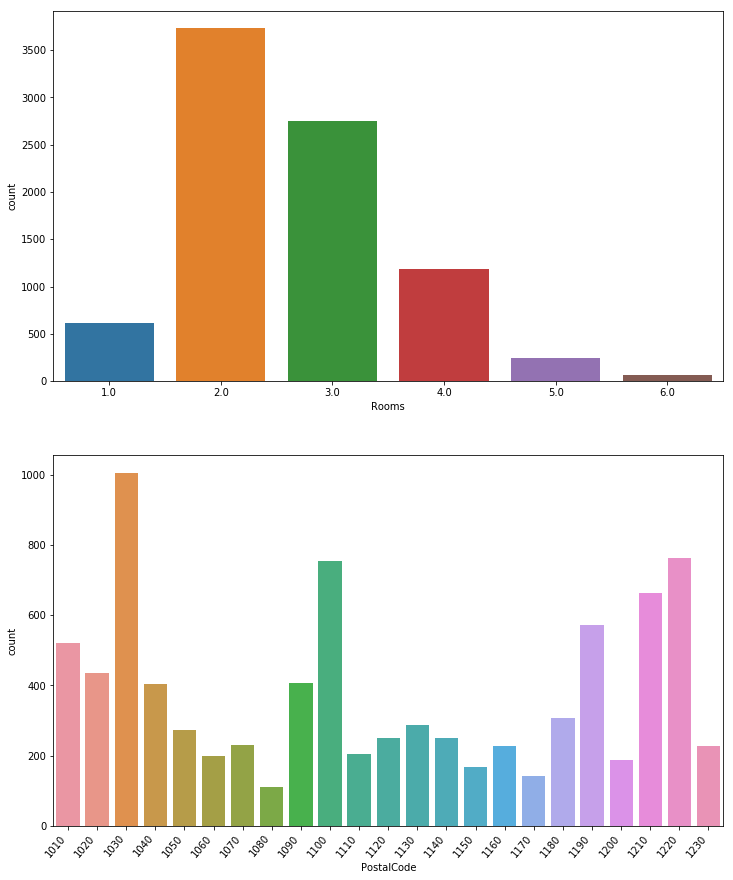

In [51]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['PostalCode'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

#### Lets plot the price vs size and check fi there are any outliers


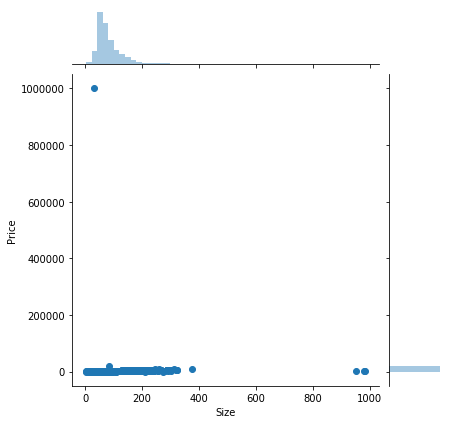

In [52]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

In [53]:
rental_properties = rental_properties[rental_properties['Price'] <= 7000]


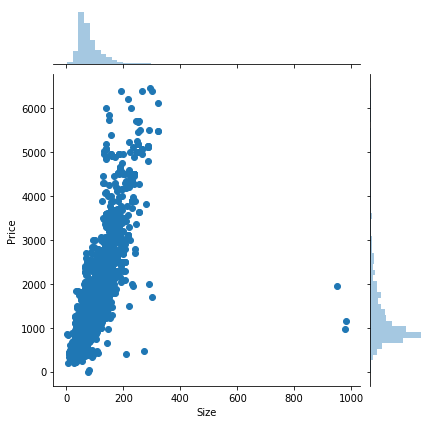

In [54]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

#### We expect the value of properties would increase as the number of rooms increases. Examining the boxplot below we see that 1 and 2 room apartments are competing in the closer price range

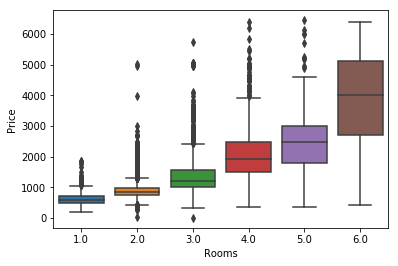

In [55]:
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

#### Boxplot below captures hat the price/m2 is in the similar price range for all size apartments besides for single room apartments where the price/m2 goes even higher

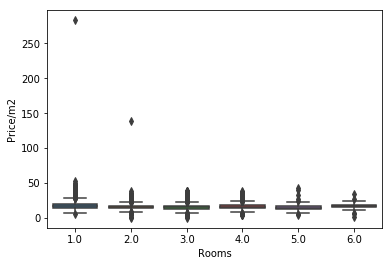

In [143]:
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

#### Let's check the differences in price per m2 in each district

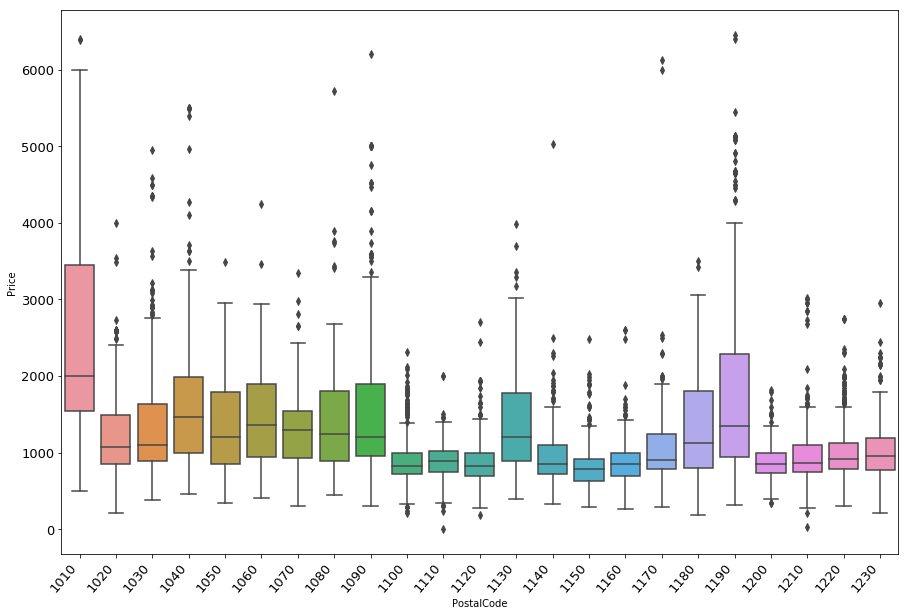

In [58]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

### Get coordinates for each district

#### Drop duplicate postal pocode to avoid fetching coordinates for the same districts . Find the unique postal codes and find the coordinates once for each district

In [59]:
vienna_districts = rental_properties[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
vienna_districts.head()

,PostalCode,District
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten


In [60]:
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])

geolocator = Nominatim(user_agent="vienna_explorer")

for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

In [61]:
district_coordinates = vienna_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209023,16.369851
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.220210,16.371216
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.202264,16.349123
7,1080,Josefstadt,48.210852,16.347360
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.152994,16.382822


#### Visualizing Vienna map with districts

In [62]:
# create map of Vienna using latitude and longitude values
map_vienna = folium.Map(location=[48.2012167,16.3725062], zoom_start=10)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

###  Visualizing the average price/m2 & average apartment size per district on a choropleth map

#### Extract only the Vienna districts from the JSON file and edit the keys to match our data 

In [ ]:
with open('gemeinden_wien_bezirke_geo.json') as json_data:
    location_data = json.load(json_data)

In [118]:
location_data['features'] = location_data['features'][:23]

In [119]:
for idx in range(len(location_data['features'])):
    location_data['features'][idx]['properties']['name'] = location_data['features'][idx]['properties']['name'].replace('Wien ','')

#### Calculate the mean per district 


In [120]:
mean_per_district = rental_properties.groupby('District').mean().reset_index()
mean_per_district.head()


,District,Size,Rooms,Price,Price/m2
0,Alsergrund,92.605392,2.683824,1546.028775,17.122230
1,Brigittenau,66.641711,2.299465,889.866043,14.232941
2,Donaustadt,63.164042,2.396325,990.300722,16.040551
3,Döbling,99.529825,3.024561,1734.930719,17.089368
4,Favoriten,59.957503,2.296149,871.775113,15.250212


#### Average price/m2 per district


In [121]:
# vienna_geo from geojson file
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

### Average apartment size per district

In [122]:
# vienna_geo = r'BEZIRKSGRENZEOGD.json' # geojson file
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Size'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartment size for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

# Foursquare data

### Lets define client and secret IDS to communicate with Foursquare API¶


In [123]:
# The code was removed by Watson Studio for sharing.

### Defining functions and making a request data from Foursquare API


In [124]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [125]:
vienna_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)

In [126]:
vienna_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209023,16.369851,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.209023,16.369851,Stephansdom,48.208626,16.372672,Church
2,Innere Stadt,48.209023,16.369851,Kolar,48.210538,16.370033,Gastropub
3,Innere Stadt,48.209023,16.369851,Park Hyatt Vienna,48.210691,16.367788,Hotel
4,Innere Stadt,48.209023,16.369851,Graben,48.208915,16.369379,Pedestrian Plaza


In [127]:
print('{} venues are collected'.format(vienna_venues.shape[0]))


1646 venues are collected


In [128]:
vienna_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,28,28,28,28,28,28
Döbling,65,65,65,65,65,65
Favoriten,48,48,48,48,48,48
Floridsdorf,42,42,42,42,42,42
Hernals,28,28,28,28,28,28
Hietzing,28,28,28,28,28,28
Innere Stadt,100,100,100,100,100,100


#### Let's find out how many unique categories can be gathered from all the returned venues

In [129]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 222 uniques categories.


## Analyzing each District

In [130]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vienna_onehot['District'] = vienna_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot.head()

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Bakery,Bar,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Campground,Canal,Candy Store,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Office,Opera House,Organic Grocery,Other Event,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Racecourse,Racetrack,Radio Station,Recreation Center,Rental Car Location,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo Exhibit
0,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Next let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [131]:

vienna_grouped = vienna_onehot.groupby('District').mean().reset_index()
vienna_grouped

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,BBQ Joint,Bakery,Bar,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Campground,Canal,Candy Store,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health Food Store,Herbs & Spices Store,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Office,Opera House,Organic Grocery,Other Event,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Racecourse,Racetrack,Radio Station,Recreation Center,Rental Car Location,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.00,0.010000,0.000000,0.00,0.010000,0.000000,0.000000,0.020000,0.020000,0.030000,0.01,0.00,0.000000,0.010000,0.000000,0.00,0.010000,0.00,0.000000,0.00,0.000000,0.00,0.010000,0.010000,0.000000,0.00,0.000000,0.000000,0.110000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.010000,0.000000,0.030000,0.05,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.01,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.010000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.050000,0.00,0.00,0.000000,0.010000,0.010000,0.00,0.000000,0.01,0.0

#### Defining a function to sort the venues in descending order & creating a new dataframe and display the top 10 venues for each district.

In [132]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [133]:
mean_per_district = rental_properties.groupby('District').mean().reset_index()
mean_per_district.head()

,District,Size,Rooms,Price,Price/m2
0,Alsergrund,92.605392,2.683824,1546.028775,17.122230
1,Brigittenau,66.641711,2.299465,889.866043,14.232941
2,Donaustadt,63.164042,2.396325,990.300722,16.040551
3,Döbling,99.529825,3.024561,1734.930719,17.089368
4,Favoriten,59.957503,2.296149,871.775113,15.250212


In [134]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = vienna_grouped['District']

for idx in np.arange(vienna_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(vienna_grouped.iloc[idx, :], num_top_venues)

In [135]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Café,Restaurant,Hotel,Coffee Shop,Park,Tapas Restaurant,Gastropub,Cocktail Bar,Bar,Pizza Place
1,Brigittenau,Supermarket,Plaza,Austrian Restaurant,Italian Restaurant,Park,Restaurant,Ice Cream Shop,Kebab Restaurant,Shopping Mall,Pool
2,Donaustadt,Bus Stop,Gastropub,Fast Food Restaurant,Supermarket,Japanese Restaurant,Café,Metro Station,Soccer Field,Breakfast Spot,Salon / Barbershop
3,Döbling,Restaurant,Austrian Restaurant,Café,Wine Bar,Bus Stop,Italian Restaurant,Scenic Lookout,Supermarket,Bakery,Mountain
4,Favoriten,Supermarket,Austrian Restaurant,Grocery Store,Park,Food & Drink Shop,Gym / Fitness Center,Café,Train Station,Fast Food Restaurant,Racetrack
5,Floridsdorf,Supermarket,Electronics Store,Grocery Store,Shopping Mall,Fast Food Restaurant,Gym / Fitness Center,Café,Flea Market,Restaurant,Brewery
6,Hernals,Austrian Restaurant,Park,Bus Stop,Pool,Hotel,Italian Restaurant,Palace,Comfort Food Restaurant,Restaurant,Climbing Gym
7,Hietzing,Park,Supermarket,Hotel,Bakery,Austrian Restaurant,Scenic Lookout,Historic Site,Gym / Fitness Center,Gastropub,Food
8,Innere Stadt,Hotel,Austrian Restaurant,Plaza,Restaurant,Italian Restaurant,Café,Bar,Ice Cream Shop,Boutique,Jazz Club
9,Josefstadt,Hotel,Plaza,Italian Restaurant,Café,Coffee Shop,Park,Pizza Place,Ice Cream Shop,Gym,Theater


# K-means Cluster

Setting up k-means:

Now that we have our data, let's set up our k-means clustering.
.

In [136]:
# set number of clusters
kclusters = 2

vienna_grouped_clustering = vienna_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

#### Let's create a dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.

In [137]:

# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add price/m2 for each district
vienna_merged = pd.merge(district_coordinates, mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
vienna_merged = vienna_merged.join(district_venues_sorted.set_index('District'), on='District')

vienna_merged

,PostalCode,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209023,16.369851,20.344605,1,Hotel,Austrian Restaurant,Plaza,Restaurant,Italian Restaurant,Café,Bar,Ice Cream Shop,Boutique,Jazz Club
1,1020,Leopoldstadt,48.200638,16.426895,16.125701,1,Restaurant,Supermarket,Hotel,Bakery,Gastropub,Beer Garden,Hot Dog Joint,Plaza,Gym / Fitness Center,Austrian Restaurant
2,1030,Landstraße,48.193644,16.396286,16.823695,1,Hotel,Restaurant,Austrian Restaurant,Pizza Place,Concert Hall,Café,Asian Restaurant,Plaza,Italian Restaurant,Steakhouse
3,1040,Wieden,48.220210,16.371216,16.717916,1,Restaurant,Hotel,Austrian Restaurant,Café,Plaza,Coffee Shop,Cocktail Bar,Pizza Place,Park,Lounge
4,1050,Margareten,48.188073,16.353386,15.157500,1,Austrian Restaurant,Bar,Hotel,Asian Restaurant,Café,Ice Cream Shop,Restaurant,Burger Joint,Indian Restaurant,Middle Eastern Restaurant
5,1060,Mariahilf,48.195475,16.347023,16.433182,1,Hotel,Austrian Restaurant,Ice Cream Shop,Pizza Place,Clothing Store,Hostel,Coffee Shop,Café,Japanese Restaurant,Seafood Restaurant
6,1070,Neubau,48.202264,16.349123,15.853609,1,Hotel,Plaza,Austrian Restaurant,Café,Park,Ice Cream Shop,Gym / Fitness Center,Theater,Pizza Place,Bar
7,1080,Josefstadt,48.210852,16.347360,15.737890,1,Hotel,Plaza,Italian Restaurant,Café,Coffee Shop,Park,Pizza Place,Ice Cream Shop,Gym,Theater
8,1090,Alsergrund,48.225073,16.358398,17.122230,1,Café,Restaurant,Hotel,Coffee Shop,Park,Tapas Restaurant,Gastropub,Cocktail Bar,Bar,Pizza Place
9,1100,Favoriten,48.152994,16.382822,15.250212,0,Supermarket,Austrian Restaurant,Grocery Store,Park,Food & Drink Shop,Gym / Fitness Center,Café,Train Station,Fast Food Restaurant,Racetrack


In [138]:
vienna_merged['Cluster Labels'].value_counts()


1    15
0     8
Name: Cluster Labels, dtype: int64

#### Finally, let's visualize the resulting k means clusters

In [139]:
# create map
map_clusters = folium.Map(location=[48.2012167,16.3725062], zoom_start=10)

# set colors
rainbow = ['green', 'cyan']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['District'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [140]:
cluster1 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 0, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster1

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Favoriten,0,Supermarket,Austrian Restaurant,Grocery Store,Park,Food & Drink Shop,Gym / Fitness Center,Café,Train Station,Fast Food Restaurant,Racetrack
10,Simmering,0,Fast Food Restaurant,Tram Station,Light Rail Station,Supermarket,Pizza Place,Bus Stop,Shopping Mall,Flower Shop,Restaurant,Café
12,Hietzing,0,Park,Supermarket,Hotel,Bakery,Austrian Restaurant,Scenic Lookout,Historic Site,Gym / Fitness Center,Gastropub,Food
17,Währing,0,Café,Supermarket,Park,Ice Cream Shop,Italian Restaurant,Bakery,Restaurant,Gastropub,Austrian Restaurant,Asian Restaurant
19,Brigittenau,0,Supermarket,Plaza,Austrian Restaurant,Italian Restaurant,Park,Restaurant,Ice Cream Shop,Kebab Restaurant,Shopping Mall,Pool
20,Floridsdorf,0,Supermarket,Electronics Store,Grocery Store,Shopping Mall,Fast Food Restaurant,Gym / Fitness Center,Café,Flea Market,Restaurant,Brewery
21,Donaustadt,0,Bus Stop,Gastropub,Fast Food Restaurant,Supermarket,Japanese Restaurant,Café,Metro Station,Soccer Field,Breakfast Spot,Salon / Barbershop
22,Liesing,0,Supermarket,Hotel,Bus Stop,Italian Restaurant,Cosmetics Shop,Plaza,Pharmacy,Metro Station,Dessert Shop,Park


### Cluster 2

In [141]:
cluster2 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 1, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster2

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innere Stadt,1,Hotel,Austrian Restaurant,Plaza,Restaurant,Italian Restaurant,Café,Bar,Ice Cream Shop,Boutique,Jazz Club
1,Leopoldstadt,1,Restaurant,Supermarket,Hotel,Bakery,Gastropub,Beer Garden,Hot Dog Joint,Plaza,Gym / Fitness Center,Austrian Restaurant
2,Landstraße,1,Hotel,Restaurant,Austrian Restaurant,Pizza Place,Concert Hall,Café,Asian Restaurant,Plaza,Italian Restaurant,Steakhouse
3,Wieden,1,Restaurant,Hotel,Austrian Restaurant,Café,Plaza,Coffee Shop,Cocktail Bar,Pizza Place,Park,Lounge
4,Margareten,1,Austrian Restaurant,Bar,Hotel,Asian Restaurant,Café,Ice Cream Shop,Restaurant,Burger Joint,Indian Restaurant,Middle Eastern Restaurant
5,Mariahilf,1,Hotel,Austrian Restaurant,Ice Cream Shop,Pizza Place,Clothing Store,Hostel,Coffee Shop,Café,Japanese Restaurant,Seafood Restaurant
6,Neubau,1,Hotel,Plaza,Austrian Restaurant,Café,Park,Ice Cream Shop,Gym / Fitness Center,Theater,Pizza Place,Bar
7,Josefstadt,1,Hotel,Plaza,Italian Restaurant,Café,Coffee Shop,Park,Pizza Place,Ice Cream Shop,Gym,Theater
8,Alsergrund,1,Café,Restaurant,Hotel,Coffee Shop,Park,Tapas Restaurant,Gastropub,Cocktail Bar,Bar,Pizza Place
11,Meidling,1,Hotel,Pub,Café,Fountain,History Museum,Italian Restaurant,Park,Pool,Zoo Exhibit,Falafel Restaurant


#### Analyzing the clusters we can see that cluster 1 is more residential since it contains lots of parks and supermarkets while cluster 2 is more commercial / touristic and contains many hotels and restaurants 

In [ ]:
# The code was removed by Watson Studio for sharing.

In [116]:
# The code was removed by Watson Studio for sharing.

## Final Visualization

With all the gathered data lets create a choropleth map displaying the average price/m2 for each district as well as display information about the area type and top 10 locations for each district on the marker labels. With this map, one could determine for example that the 1st district is the most expensive district to live in, however by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the 1st district, they could look for apartments in the 12th or 15th district which is similar in venues but has much lower price for renting apartments.

In [142]:
# Vienna map
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# set colors
marker_colors = ['green', 'cyan']

# add markers for e
for idx in range(len(vienna_merged)):
    html_label = ''
    
    lat = vienna_merged['Latitude'].loc[idx]
    lng = vienna_merged['Longitude'].loc[idx]
    district_num = (vienna_merged['PostalCode'].loc[idx])[1:3]
    district = vienna_merged['District'].loc[idx]
    cluster = vienna_merged['Cluster Labels'].loc[idx]
    average_price = vienna_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + str(district_num) + '. ' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 16):
        html_label += '<li>' + vienna_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(vienna_map)

# display map
vienna_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
